## Assignment 2: Aircraft Routing Problem - Dynamic Programming
Group:  28 <br>
Authors:   Thieme Brandwagt and Sam Buisman <br>
Date: 16-01-2025

Scroll down for complete code (run in one cell)


### Import necessary libraries

In [46]:
# Import necessary packages
from openpyxl import *
import math
import pandas as pd
import numpy as np

### Import data from Excel files

In [47]:
# Load airport data into a numpy array
file_path_airports = "DATA/AirportData.xlsx"
airports_df = pd.read_excel(file_path_airports, usecols ="B:U")
airports = airports_df.to_numpy()
print(airports[3][0])
# Create list for all the airports (columns)
cities = airports_df.columns
print(cities[0])

# Load fleet data into a numpy array
file_path_fleet = "DATA/FleetType.xlsx"
fleet_df = pd.read_excel(file_path_fleet)
fleet_df = fleet_df.set_index("Aircraft Type")
fleet = fleet_df.to_numpy()
print(fleet[0][0])

# Create list for all the aircraft types (columns)
aircraft_types = fleet_df.columns
print(aircraft_types[0])


# Load demand data into a numpy array
file_path_demand = "DATA/Group28.xlsx"
demand_df = pd.read_excel(file_path_demand, usecols="B:AG", skiprows=4)
demand = demand_df.to_numpy()
print(demand[0][0])

# Create a triple dimensional array for demand data (origin x destination x time)
demand_matrix = np.zeros((len(cities), len(cities), demand.shape[1] - 2))
# Populate matrix with all demand from all intervals
for rows in range(len(cities)):
    for columns in range(len(cities)):
        for time_steps in range(int(120/4)):  # 120 hours devided by 4 hour time steps
            demand_matrix[rows][columns][time_steps] = demand[rows * 20 + columns][time_steps + 2]
print(demand_matrix[3][4][int(205/40)])
# Set a city as the hub
hub = 3

3200
London
800.0
Type 1: Small freighter
LHR
166407.86847940294


### Create functions to calculate the flight details

In [48]:
# Adding the previous two bins to the currect bin to get total demand
def flow(i, j, t):
    return demand_matrix[i,j,t] + 0.2 * (demand_matrix[i,j,t-1]+demand_matrix[i,j,t-2])

# Calculate the distance between two airports
def distance(i, j):
    if i != j:
        lat_i, long_i = airports[1][i], airports[2][i]
        lat_j, long_j = airports[1][j], airports[2][j]
        delta_lat = lat_j - lat_i
        delta_long = long_j - long_i
        root = math.sin(math.radians(delta_lat)/2)**2 + math.cos(math.radians(lat_i)) \
            * math.cos(math.radians(lat_j)) * math.sin(math.radians(delta_long)/2)**2
        return 6371 * 2 * math.asin(math.sqrt(root)) 
    else:
        return 0

# Calculate the profit for each flight leg
def cost_flight_leg(i, j, k):
    if i != j:
        tc = fleet[7][k] * (distance(i, j) / fleet[0][k])     # formula for the time costs
        fc = ((fleet[8][k] * 1.42) / 1.5) * distance(i, j)    # formula for the fuel costs
        foc = fleet[6][k]                                               # formula for the fixed operating costs
        return tc + fc + foc

# Calculate the demand that can be satisfied by each flight (minimum of the demand (incl. 2 previous bins) and the capacity)
def satisfied_demand(i,j,k,n):
    return min(flow(i,j,math.floor(n / 40)), fleet[1][k])

# Calculate the profit for each flight leg
def profit(i, j, k, n):
    if i != j:
        revenue = 0.26 * distance(i,j) * satisfied_demand(i, j, k, n) / 1000
        costs = cost_flight_leg(i,j,k)
        return revenue - costs
    else:
        return 0

# Calculate the block time for each flight leg
def get_block_time(i,j,k):
    return distance(i, j) / fleet[0][k] * 60 + 30

# Adding average TAT to the block time for the total the flight duration of each flight leg
def flight_duration(i,j,k):
    return get_block_time(i,j,k) + fleet[2][k] # Round up to the nearest 6-fold

# Calculate the number of stages for each flight leg
def get_stages_in_flight(i,j,k):
    return math.ceil((flight_duration(i,j,k)) / 6)

### Define functions to find the optimal route for aircraft type k

In [49]:

def get_candidates(i,k,n):    
    candidates = []
    if i == hub:                 
        for j in range(len(cities)):                                                        
            if i == j:
                arrival_stage = n+1
                if arrival_stage < 1200:                                             # make sure no airplane is flying after the fifth day
                    candidates.append([n, arrival_stage, i, j, 0, 0, 0])             # grounded at hub
            else:
                arrival_stage = n+get_stages_in_flight(i,j,k)
                if arrival_stage < 1200:
                    candidates.append([n, arrival_stage, i, j, satisfied_demand(i,j,k,n), get_block_time(i,j,k), profit(i,j,k,n)]) # flight to spoke
        
    else:
        if n+1 < 1200:
            candidates.append([n, n+1 ,i,i, 0, 0, 0])   
        arrival_stage = n+get_stages_in_flight(i,hub,k)                              # grounded at spoke
        if arrival_stage < 1200:
            candidates.append([n, arrival_stage, i, hub, satisfied_demand(i, hub, k, n), get_block_time(i,hub,k), profit(i,hub,k,n)])     # flight to hub
    return candidates


memo = {}

def get_best_path(departure_airport, k, departure_stage):
    # Check if the result is already cached
    if (departure_airport, k, departure_stage) in memo:
        return memo[(departure_airport, k, departure_stage)]
    
    paths = []
    
    for c in get_candidates(departure_airport, k, departure_stage):
        arrival_stage = c[1]
        arrival_airport = c[3]
        future_flights = get_best_path(arrival_airport, k, arrival_stage)
        
        if future_flights:
            for flight in future_flights:
                if distance(c[2], c[3]) <= fleet[3][k] and airports[3][c[2]] >= fleet[4][k] and airports[3][c[3]] >= fleet[4][k]:
                    total_profit = c[-1] + flight[0]  # Add current profit to future route's profit
                    total_block = c[-2] + flight[1]   # Add current block time to future route's block time

                    # Add the total profit to the route and print only the flight actions (not the grounding)
                    if c[2] != c[3]:
                        paths.append([total_profit, total_block, [c[0], c[1], c[2], c[3], c[4]]] + flight[2:])
                    else:
                        paths.append([total_profit] + flight[1:])
        else:
            total_profit = c[-1]  # Profit for the last segment
            total_block = c[-2]   # Block time for the last segment
            paths.append([total_profit, total_block, [c[0], c[1], c[2], c[3], c[4]]])
    
    # Filter routes that end at the hub 
    valid_paths = [flight for flight in paths if flight[-1][3] == hub]
    # Only keep the route with the highest profit for each departure_airport
    valid_paths = sorted(valid_paths, key=lambda flight: flight[0], reverse=True)
    
    if valid_paths:
        max_profit_path = valid_paths[0]  # Take the route with the highest profit
        memo[(departure_airport, k, departure_stage)] = [max_profit_path]  # Cache only the highest profit route for the current stage
    else:
        memo[(departure_airport, k, departure_stage)] = []
    
    return memo[(departure_airport, k, departure_stage)]

# Clear the memo dictionary before running to avoid stale data
memo.clear()

get_best_path(3, 0, 0)

[[13690.753708397682,
  1910.6055571854104,
  [205, 243, 3, 4, 23000.0],
  [243, 281, 4, 3, 23000.0],
  [281, 319, 3, 4, 23000.0],
  [319, 357, 4, 3, 23000.0],
  [359, 398, 3, 15, 23000.0],
  [519, 558, 15, 3, 20234.559767878545],
  [559, 597, 3, 4, 23000.0],
  [719, 757, 4, 3, 23000.0],
  [761, 799, 3, 4, 23000.0],
  [799, 837, 4, 3, 23000.0],
  [921, 959, 3, 18, 23000.0],
  [959, 997, 18, 3, 23000.0],
  [1001, 1039, 3, 4, 23000.0],
  [1039, 1077, 4, 3, 23000.0],
  [1198, 1199, 3, 3, 0]]]

### Create algorithm that iterates the route finding problem over all available aircraft

In [ ]:
# Create a function to print the flight schedule of the most profitable route by aircraft type k
def get_flight_schedule(best_route, ac_best_route):
    def get_time(n):
        day     = int(n/240+1)
        hours   = int((n - ((day-1) * 240)) / 10)
        minutes = int((n - ((day-1) * 240 + hours * 10)) * 6)
        return [day, hours, minutes]
    
    schedule = {}
    
    # Group flights by day
    print("-------------------------------------------")
    print("Route flown by aircraft ", aircraft_types[ac_best_route])
    for flight in best_route[:-1]:
        time_dep = f"{get_time(flight[0])[1]:02d}:{get_time(flight[0])[2]:02d}"
        time_arr = f"{get_time(flight[1])[1]:02d}:{get_time(flight[1])[2]:02d}"
        flight_day = get_time(flight[0])[0]
        flight_dep_ap = cities[flight[2]]
        flight_arr_ap = cities[flight[3]]
        flight_demand = flight[4]
        
        # Create list for day if it doesn't exist
        if flight_day not in schedule:
            schedule[flight_day] = []
        
        # Add flight to appropriate day
        schedule[flight_day].append(f"{time_dep}  {time_arr}  {flight_dep_ap} - {flight_arr_ap}  {round(flight_demand,1)}")

    # Print schedule by day
    for day in sorted(schedule.keys()):
        print(f"Day {day}")
        for flight in schedule[day]:
            print(flight)
    
    return ac_best_route, best_route 

# ---------------------------------------------------------------------------------------------------------------------

# Create an algorithm to choose the best most profitable aircraft out of all available aircrafts
def choose_ac(departure_airport=hub, departure_stage=0):
    available_ac = (fleet[9])   # tuple of available aircrafts
    ac_list = [*available_ac]   # list of available aircrafts
    iterations = 1
    flown_route = []
    global best_routes, ac_best_route       # global variables to store the best routes and it's aircraft type
    best_routes = []

    # Keep initiating aircrafts untill all aircrafts are used
    while not all(ac == 0 for ac in ac_list):
        print("=================================================================")
        print("iteration: ", iterations)
        print("available aircrafts: type 1: ", ac_list[0], " | type 2: ", ac_list[1], " | type 3: ", ac_list[2])
        memo.clear()
        best_profit = 0              # set the lowest bound to 0
        block_time = [0] * len(ac_list)     # create a list to store the block time for each aircraft type
        ac_best_route = None                # set the most profitable aircraft type to None at start of iteration
        k_available = -1                        # create an index for the amount of available routes
        for k in range(len(ac_list)):
            # Check if there are any aircrafts available of type k, if so, get the best path for that aircraft type
            if ac_list[k] >= 1:
                k_available += 1                # increase the index for the amount of available routes
                flown_route.append(get_best_path(departure_airport, k, departure_stage)[0])
                print(flown_route[k_available])
                block_time[k] = flown_route[k_available][1]
                # Check which aircraft type has the highest profit
                if flown_route[k_available][0] - fleet[5][k]*5 > best_profit:
                    # Save the best profit and aircraft type used in the most profitable route
                    best_profit = flown_route[k_available][0] - fleet[5][k]*5
                    best_route = flown_route[k_available][2:]
                    ac_best_route = k        # save the most profitable aircraft type   
                    best_k_aivailable = k_available   # save the index of the most profitable route from all available
                # Don't consider aircraft type that can't make a profit or reach the minimum block time of 6 hours per day
                if flown_route[k_available][0] - fleet[5][k]*5 <= 0 or block_time[k] <= 60 * 6 * 5:
                    ac_list[k] = 0

        if not all(ac == 0 for ac in ac_list) and ac_best_route != None:
            print(flown_route[0][1])
            print("k_index: ", k_available)	
            print("most profitable aircraft type: ", ac_best_route + 1)
            print("profit made: ", best_profit)
            print("total block time: ", flown_route[best_k_aivailable][1])
            print("route flown: ",get_flight_schedule(best_route, ac_best_route))
            ac_list[ac_best_route] -= 1
            

            # Subtract satisfied demand from the demand matrix
            for flight in range(len(flown_route[best_k_aivailable][2:])):       # loop through all flights in the route
                flown_demand = [0] * len(flown_route[best_k_aivailable][2:])    # create lists with amount of instances equal to the amount flights
                flown_bin =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_dep =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_arr =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_demand[flight] = flown_route[best_k_aivailable][2:][flight][-1]
                flown_bin[flight] = int(flown_route[best_k_aivailable][2:][flight][0] / 40)
                flown_dep[flight] = flown_route[best_k_aivailable][2:][flight][2]
                flown_arr[flight] = flown_route[best_k_aivailable][2:][flight][3]
                if flown_demand[flight] < demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]]:
                    demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]] -= flown_demand[flight]
                else:
                    demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]] = 0
                    rest_demand_first = flown_demand[flight] - demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]]
                    if rest_demand_first < demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]]:
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]] -= rest_demand_first
                    else:
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]] = 0
                        rest_demand_second = rest_demand_first - demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]]
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 2]] -= rest_demand_second
            flown_route.clear()
        
        else:
            print("no more aircrafts available or profitable")
        iterations += 1
        

choose_ac()

iteration:  1
available aircrafts: type 1:  2.0  | type 2:  2.0  | type 3:  1.0
[13690.753708397682, 1910.6055571854104, [205, 243, 3, 4, 23000.0], [243, 281, 4, 3, 23000.0], [281, 319, 3, 4, 23000.0], [319, 357, 4, 3, 23000.0], [359, 398, 3, 15, 23000.0], [519, 558, 15, 3, 20234.559767878545], [559, 597, 3, 4, 23000.0], [719, 757, 4, 3, 23000.0], [761, 799, 3, 4, 23000.0], [799, 837, 4, 3, 23000.0], [921, 959, 3, 18, 23000.0], [959, 997, 18, 3, 23000.0], [1001, 1039, 3, 4, 23000.0], [1039, 1077, 4, 3, 23000.0], [1198, 1199, 3, 3, 0]]
[10009.980782800758, 797.9900109728932, [225, 279, 3, 17, 28541.47812316272], [279, 333, 17, 3, 35000.0], [519, 573, 3, 17, 35000.0], [959, 1013, 17, 3, 35000.0], [1198, 1199, 3, 3, 0]]
[39172.36770730437, 598.7841693231244, [233, 279, 3, 4, 120000.0], [279, 325, 4, 3, 75799.45776055097], [440, 474, 3, 2, 117485.17653180443], [479, 513, 2, 3, 84008.92687580091], [519, 565, 3, 4, 66749.28638117695], [1039, 1085, 4, 3, 64434.1580591777], [1198, 1199, 3, 3, 

### Print the flight schedule

# Complete code for single run

In [52]:
# Import necessary packages
from openpyxl import *
import math
import pandas as pd
import numpy as np

#---------------------------------------------------------------------------------------------------------------------

# Load airport data into a numpy array
file_path_airports = "DATA/AirportData.xlsx"
airports_df = pd.read_excel(file_path_airports, usecols ="B:U")
airports = airports_df.to_numpy()
# Create list for all the airports (columns)
cities = airports_df.columns


# Load fleet data into a numpy array
file_path_fleet = "DATA/FleetType.xlsx"
fleet_df = pd.read_excel(file_path_fleet)
fleet_df = fleet_df.set_index("Aircraft Type")
fleet = fleet_df.to_numpy()
# Create list for all the aircraft types (columns)
aircraft_types = fleet_df.columns

# Load demand data into a numpy array
file_path_demand = "DATA/Group28.xlsx"
demand_df = pd.read_excel(file_path_demand, usecols="B:AG", skiprows=4)
demand = demand_df.to_numpy()
# Create a triple dimensional array for demand data (origin x destination x time)
demand_matrix = np.zeros((len(cities), len(cities), demand.shape[1] - 2))
# Populate matrix with all demand from all intervals
for rows in range(len(cities)):
    for columns in range(len(cities)):
        for time_steps in range(int(120/4)):  # 120 hours devided by 4 hour time steps
            demand_matrix[rows][columns][time_steps] = demand[rows * 20 + columns][time_steps + 2]
# Set a city as the hub
hub = 3

#---------------------------------------------------------------------------------------------------------------------

# Adding the previous two bins to the currect bin to get total demand
def flow(i, j, t):
    return demand_matrix[i,j,t] + 0.2 * (demand_matrix[i,j,t-1]+demand_matrix[i,j,t-2])

# Calculate the distance between two airports
def distance(i, j):
    if i != j:
        lat_i, long_i = airports[1][i], airports[2][i]
        lat_j, long_j = airports[1][j], airports[2][j]
        delta_lat = lat_j - lat_i
        delta_long = long_j - long_i
        root = math.sin(math.radians(delta_lat)/2)**2 + math.cos(math.radians(lat_i)) \
            * math.cos(math.radians(lat_j)) * math.sin(math.radians(delta_long)/2)**2
        return 6371 * 2 * math.asin(math.sqrt(root)) 
    else:
        return 0

# Calculate the profit for each flight leg
def cost_flight_leg(i, j, k):
    if i != j:
        tc = fleet[7][k] * (distance(i, j) / fleet[0][k])     # formula for the time costs
        fc = ((fleet[8][k] * 1.42) / 1.5) * distance(i, j)    # formula for the fuel costs
        foc = fleet[6][k]                                               # formula for the fixed operating costs
        return tc + fc + foc

# Calculate the demand that can be satisfied by each flight (minimum of the demand (incl. 2 previous bins) and the capacity)
def satisfied_demand(i,j,k,n):
    return min(flow(i,j,math.floor(n / 40)), fleet[1][k])

# Calculate the profit for each flight leg
def profit(i, j, k, n):
    if i != j:
        revenue = 0.26 * distance(i,j) * satisfied_demand(i, j, k, n) / 1000
        costs = cost_flight_leg(i,j,k)
        return revenue - costs
    else:
        return 0

# Calculate the block time for each flight leg
def get_block_time(i,j,k):
    return distance(i, j) / fleet[0][k] * 60 + 30

# Adding average TAT to the block time for the total the flight duration of each flight leg
def flight_duration(i,j,k):
    return get_block_time(i,j,k) + fleet[2][k] # Round up to the nearest 6-fold

# Calculate the number of stages for each flight leg
def get_stages_in_flight(i,j,k):
    return math.ceil((flight_duration(i,j,k)) / 6)

#---------------------------------------------------------------------------------------------------------------------

# Create a function to get all possible actions for each aircraft at each state
def get_candidates(i,k,n):    
    candidates = []
    if i == hub:                 
        for j in range(len(cities)):                                                        
            if i == j:
                arrival_stage = n+1
                if arrival_stage < 1200:                                                     # make sure no airplane is flying after the fifth day
                    candidates.append([n, arrival_stage, i, j, 0, 0, 0])             # grounded at hub
            else:
                arrival_stage = n+get_stages_in_flight(i,j,k)
                if arrival_stage < 1200:
                    candidates.append([n, arrival_stage, i, j, satisfied_demand(i,j,k,n), get_block_time(i,j,k), profit(i,j,k,n)]) # flight to spoke
        
    else:
        if n+1 < 1200:
            candidates.append([n, n+1 ,i,i, 0, 0, 0])   
        arrival_stage = n+get_stages_in_flight(i,hub,k)                               # grounded at spoke
        if arrival_stage < 1200:
            candidates.append([n, arrival_stage, i, hub, satisfied_demand(i, hub, k, n), get_block_time(i,hub,k), profit(i,hub,k,n)])     # flight to hub
    return candidates

# Create an algorithm to find the best path for each aircraft type
memo = {} # Create a dictionary to store the results
def get_best_path(departure_airport, k, departure_stage):
    # Check if the result is already cached
    if (departure_airport, k, departure_stage) in memo:
        return memo[(departure_airport, k, departure_stage)]
    
    routes = []
    
    for c in get_candidates(departure_airport, k, departure_stage):
        arrival_stage = c[1]
        arrival_airport = c[3]
        future_routes = get_best_path(arrival_airport, k, arrival_stage)
        
        if future_routes:
            for route in future_routes:
                if distance(c[2], c[3]) <= fleet[3][k] and airports[3][c[2]] >= fleet[4][k] and airports[3][c[3]] >= fleet[4][k]:
                    total_profit = c[-1] + route[0]  # Add current profit to future route's profit
                    total_block = c[-2] + route[1]   # Add current block time to future route's block time

                    # Add the total profit to the route and print only the flight actions (not the grounding)
                    if c[2] != c[3]:
                        routes.append([total_profit, total_block, [c[0], c[1], c[2], c[3], c[4]]] + route[2:])
                    else:
                        routes.append([total_profit] + route[1:])
        else:
            total_profit = c[-1]  # Profit for the last segment
            total_block = c[-2]   # Block time for the last segment
            routes.append([total_profit, total_block, [c[0], c[1], c[2], c[3], c[4]]])
    
    # Filter routes that end at the hub 
    valid_routes = [route for route in routes if route[-1][3] == hub]
    # Only keep the route with the highest profit for each departure_airport
    valid_routes = sorted(valid_routes, key=lambda route: route[0], reverse=True)
    
    if valid_routes:
        max_profit_route = valid_routes[0]  # Take the route with the highest profit
        memo[(departure_airport, k, departure_stage)] = [max_profit_route]  # Cache only the highest profit route for the current stage
    else:
        memo[(departure_airport, k, departure_stage)] = []
    
    return memo[(departure_airport, k, departure_stage)]

# Clear the memo dictionary before running to avoid stale data
memo.clear()

#---------------------------------------------------------------------------------------------------------------------

# Create a function to print the flight schedule of the most profitable route by aircraft type k
def get_flight_schedule(best_route, ac_best_route):
    def get_time(n):
        day     = int(n/240+1)
        hours   = int((n - ((day-1) * 240)) / 10)
        minutes = int((n - ((day-1) * 240 + hours * 10)) * 6)
        return [day, hours, minutes]
    
    schedule = {}
    
    # Group flights by day
    print("-------------------------------------------")
    print("Route flown by aircraft ", aircraft_types[ac_best_route])
    for flight in best_route[:-1]:
        time_dep = f"{get_time(flight[0])[1]:02d}:{get_time(flight[0])[2]:02d}"
        time_arr = f"{get_time(flight[1])[1]:02d}:{get_time(flight[1])[2]:02d}"
        flight_day = get_time(flight[0])[0]
        flight_dep_ap = cities[flight[2]]
        flight_arr_ap = cities[flight[3]]
        flight_demand = flight[4]
        
        # Create list for day if it doesn't exist
        if flight_day not in schedule:
            schedule[flight_day] = []
        
        # Add flight to appropriate day
        schedule[flight_day].append(f"{time_dep}  {time_arr}  {flight_dep_ap} - {flight_arr_ap}  {round(flight_demand,1)}")

    # Print schedule by day
    for day in sorted(schedule.keys()):
        print(f"Day {day}")
        for flight in schedule[day]:
            print(flight)
    
    return ac_best_route, best_route 

# ---------------------------------------------------------------------------------------------------------------------

# Create an algorithm to choose the best most profitable aircraft out of all available aircrafts
def choose_ac(departure_airport=hub, departure_stage=0):
    available_ac = (fleet[9])   # tuple of available aircrafts
    ac_list = [*available_ac]   # list of available aircrafts
    iterations = 1
    flown_route = []
    global best_routes, ac_best_route       # global variables to store the best routes and it's aircraft type
    best_routes = []

    # Keep initiating aircrafts untill all aircrafts are used
    while not all(ac == 0 for ac in ac_list):
        print("=================================================================")
        print("iteration: ", iterations)
        print("available aircrafts: type 1: ", ac_list[0], " | type 2: ", ac_list[1], " | type 3: ", ac_list[2])
        memo.clear()
        best_profit = -0                                # set the lowest bound to 0 (can be adjusted to -100,000 to see all routes)
        block_time = [0] * len(ac_list)                 # create a list to store the block time for each aircraft type
        ac_best_route = None                            # set the most profitable aircraft type to None at start of iteration
        k_available = -1                                # create an index for the amount of available routes
        for k in range(len(ac_list)):
            # Check if there are any aircrafts available of type k, if so, get the best path for that aircraft type
            if ac_list[k] >= 1:
                k_available += 1                        # increase the index for the amount of available routes
                flown_route.append(get_best_path(departure_airport, k, departure_stage)[0])
                print(flown_route[k_available])
                block_time[k] = flown_route[k_available][1]
                # Check if the current aircraft type has a positive profit and a block time of at least 6 hours
                if flown_route[k_available][0] - fleet[5][k]*5 > best_profit and block_time[k] >= 60 * 6 * 5:
                    # Save the best profit and aircraft type used in the most profitable route
                    best_profit = flown_route[k_available][0] - fleet[5][k]*5
                    best_route = flown_route[k_available][2:]
                    ac_best_route = k                   # save the most profitable aircraft type   
                    best_k_aivailable = k_available     # save the index of the most profitable route from all available
                # Don't consider aircraft type that can't make a profit or reach the minimum block time of 6 hours per day
                if flown_route[k_available][0] - fleet[5][k]*5 <= 0 or block_time[k] <= 60 * 6 * 5:
                    ac_list[k] = 0

        if not all(ac == 0 for ac in ac_list) and ac_best_route != None:
            print("most profitable aircraft type: ", ac_best_route + 1)
            print("profit made: ", best_profit)
            print("total block time: ", flown_route[best_k_aivailable][1])
            print("route flown: ",get_flight_schedule(best_route, ac_best_route))
            ac_list[ac_best_route] -= 1
            

            # Subtract satisfied demand from the demand matrix
            for flight in range(len(flown_route[best_k_aivailable][2:])):       # loop through all flights in the route
                flown_demand = [0] * len(flown_route[best_k_aivailable][2:])    # create lists with amount of instances equal to the amount flights
                flown_bin =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_dep =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_arr =    [0] * len(flown_route[best_k_aivailable][2:])
                flown_demand[flight] = flown_route[best_k_aivailable][2:][flight][-1]
                flown_bin[flight] = int(flown_route[best_k_aivailable][2:][flight][0] / 40)
                flown_dep[flight] = flown_route[best_k_aivailable][2:][flight][2]
                flown_arr[flight] = flown_route[best_k_aivailable][2:][flight][3]
                if flown_demand[flight] < demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]]:
                    demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]] -= flown_demand[flight]
                else:
                    demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]] = 0
                    rest_demand_first = flown_demand[flight] - demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight]]
                    if rest_demand_first < demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]]:
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]] -= rest_demand_first
                    else:
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]] = 0
                        rest_demand_second = rest_demand_first - demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 1]]
                        demand_matrix[flown_dep[flight]][flown_arr[flight]][flown_bin[flight - 2]] -= rest_demand_second
            flown_route.clear()
        
        else:
            print("no more aircrafts available or profitable")
        iterations += 1
        
choose_ac()

iteration:  1
available aircrafts: type 1:  2.0  | type 2:  2.0  | type 3:  1.0
[13690.753708397682, 1910.6055571854104, [205, 243, 3, 4, 23000.0], [243, 281, 4, 3, 23000.0], [281, 319, 3, 4, 23000.0], [319, 357, 4, 3, 23000.0], [359, 398, 3, 15, 23000.0], [519, 558, 15, 3, 20234.559767878545], [559, 597, 3, 4, 23000.0], [719, 757, 4, 3, 23000.0], [761, 799, 3, 4, 23000.0], [799, 837, 4, 3, 23000.0], [921, 959, 3, 18, 23000.0], [959, 997, 18, 3, 23000.0], [1001, 1039, 3, 4, 23000.0], [1039, 1077, 4, 3, 23000.0], [1198, 1199, 3, 3, 0]]
[10009.980782800758, 797.9900109728932, [225, 279, 3, 17, 28541.47812316272], [279, 333, 17, 3, 35000.0], [519, 573, 3, 17, 35000.0], [959, 1013, 17, 3, 35000.0], [1198, 1199, 3, 3, 0]]
[39172.36770730437, 598.7841693231244, [233, 279, 3, 4, 120000.0], [279, 325, 4, 3, 75799.45776055097], [440, 474, 3, 2, 117485.17653180443], [479, 513, 2, 3, 84008.92687580091], [519, 565, 3, 4, 66749.28638117695], [1039, 1085, 4, 3, 64434.1580591777], [1198, 1199, 3, 3, 

### Optional code for visualizing results
Not yet adjusted to show more than one route

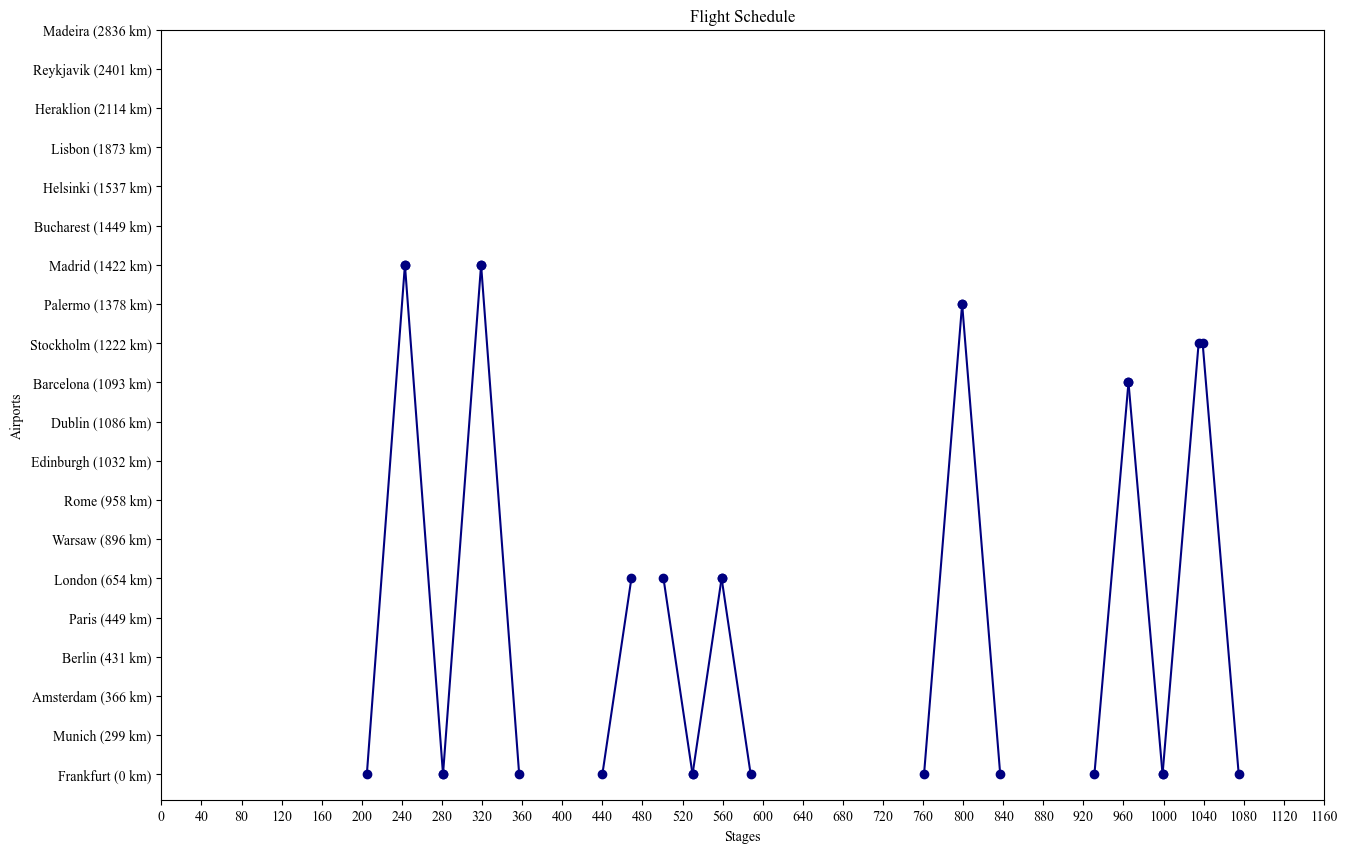

In [53]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Stel het lettertype in op Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# Assuming `flight_schedule` is the output from `get_best_path` function
flight_schedule = get_best_path(3, 0, 0)[0][2:]

# Sort airports by distance from the hub (Frankfurt)
hub_index = 3
distances = [(i, distance(hub_index, i)) for i in range(len(cities))]
sorted_airports = sorted(distances, key=lambda x: x[1])

# Create a mapping from airport index to y-axis position
airport_to_y = {airport[0]: idx for idx, airport in enumerate(sorted_airports)}

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each flight
for flight in flight_schedule:
    dep_stage, arr_stage, dep_airport, arr_airport, cargo = flight
    if dep_airport != arr_airport:
        ax.plot([dep_stage, arr_stage], [airport_to_y[dep_airport], airport_to_y[arr_airport]], marker='o', color='navy')

# Set y-axis labels to airport names
ax.set_yticks(range(len(cities)))
ax.set_yticklabels([cities[airport[0]] for airport in sorted_airports])

# Set y-axis positions proportional to distance from Frankfurt
y_positions = [airport[1] for airport in sorted_airports]
ax.set_yticks(range(len(cities)))
ax.set_yticklabels([cities[airport[0]] for airport in sorted_airports])
ax.set_yticks([airport_to_y[airport[0]] for airport in sorted_airports])
ax.set_yticklabels([f"{cities[airport[0]]} ({int(airport[1])} km)" for airport in sorted_airports])

# Set x-axis labels to show every 40th stage
ax.set_xticks(range(0, 1200, 40))
ax.set_xticklabels(range(0, 1200, 40))

# Add labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Airports')
ax.set_title('Flight Schedule')

plt.show()
